# \begin{aligned}  \textbf{ Tabular Q-learning implementation in the MiniGrid-Empty-8x8 environment } 
\end{aligned} 

## Import necessary library

In [1]:
import gymnasium as gym
import minigrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter

pygame 2.5.0 (SDL 2.28.0, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 1) Warmup Task

Write a Python script that has an agent that generates random actions every step

In [2]:
class Agent:
    def __init__(self, action_space):
        self.action_space = action_space

    def get_action(self):
        return random.choice(self.action_space)

# Define the action space
actions = ['up', 'down', 'left', 'right']

# Create an instance of the agent
agent = Agent(actions)

# Define the number of steps
num_steps = 10

# Run the simulation for 10 steps
for step in range(num_steps):
    action = agent.get_action()
    print(f"Step {step + 1}: Agent performs action '{action}'")    

Step 1: Agent performs action 'right'
Step 2: Agent performs action 'left'
Step 3: Agent performs action 'up'
Step 4: Agent performs action 'down'
Step 5: Agent performs action 'up'
Step 6: Agent performs action 'up'
Step 7: Agent performs action 'right'
Step 8: Agent performs action 'down'
Step 9: Agent performs action 'right'
Step 10: Agent performs action 'right'


In this script, the Agent class represents the agent that performs actions. The get_action method randomly selects an action from the provided action space. After choosing our four actions 'up', 'down', 'left'and 'right', we then created an instance of Agent with 10 actions and call the get_action method to generate a random action at each step.

# 2) Task 1 - Tabular Q-learning

To implement the tabular Q-learning agent and train a policy, we can follow these steps:

### Make the gym environment

In [3]:
# Make the gym environment
env = gym.make('MiniGrid-Empty-8x8-v0')

# reset the environment
obs, info = env.reset()

We first create a Gym environment using the MiniGrid-Empty-8x8-v0 environment specification. Then, we reset the environment and returns the initial observation and information about the environment's state. This allows us to start interacting with the environment and perform actions based on the observations received.

### Generate a unique key for each state

Let's use a hash function to generate a unique key for each state of the agent. We will use the Python hash() function to generate the keys.

In [4]:
def hash_state(state):
    return hash(str(state))

The 'hash_state' function takes a state as input and converts it into a hash value using the 'hash()' function in Python. It achieves this by converting the state to a string using str(state) and then applying the 'hash()' function to generate a unique hash value. The advantage of using this function is that it provides a unique identifier for each state, allowing you to store and retrieve information related to specific states efficiently. 

### Implement the epsilon-greedy exploration strategy. 

At each step, we select an action based on the epsilon-greedy policy. With a probability of epsilon, we choose a random action. Otherwise, we choose the action with the highest Q-value for the current state.

In [5]:
def epsilon_greedy(state, epsilon):
    num_actions=3
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        state_hash = hash_state(state)
        if state_hash not in Q:
            Q[state_hash] = np.zeros(num_actions)
        return np.argmax(Q[state_hash])

the function chooses a random action with probability epsilon to explore different possibilities, and chooses the action with the highest Q-value with probability (1 - epsilon) to exploit the learned knowledge and make optimal decisions.

### Perform Q-learning for a maximum of 3000 episodes

In [6]:
# Initialize the Q-table
Q = {}
num_actions=3
num_training_episodes=3000
def train_q_learning( alpha, gamma, epsilon_max, epsilon_min, epsilon_decay):

    # Tensorboard writer
    writer = SummaryWriter()

    steps_done = 0

    # Training loop
    rewards = []
    epsilon = epsilon_max

    #print('Start training...')

    for episode in range(num_training_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(env.max_steps):
            action = epsilon_greedy(state, epsilon)

            steps_done += 1

            next_state, reward, done, truncated, info = env.step(action)

            state_hash = hash_state(state)
            next_state_hash = hash_state(next_state)

            if state_hash not in Q:
                Q[state_hash] = np.zeros(num_actions)

            if next_state_hash not in Q:
                Q[next_state_hash] = np.zeros(num_actions)

            # Q-learning update rule
            Q[state_hash][action] += alpha * (reward + gamma * np.max(Q[next_state_hash]) - Q[state_hash][action])
            total_reward += reward

            if done:
                # If agent reached its goal successfully
                #print('Finished episode successfully taking %d steps and receiving reward %f' % (step, reward))
                break
            elif truncated:
                # Agent failed to reach its goal successfully
                #print('Truncated episode taking %d steps and receiving reward %f' % (step, reward))
                break

            state = next_state

        rewards.append(total_reward)

        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)
        writer.add_scalar("Reward/train", reward, steps_done)

    #print('Training completed.')
    writer.flush()
    writer.close()

    return rewards,Q


The 'train_q_learning' function takes hyperparameters as inputs and trains an agent using the Q-learning algorithm. The agent interacts with the environment for 3000 episodes, selecting actions based on an epsilon-greedy strategy. Q-values are updated using the Q-learning rule, considering rewards and the maximum Q-value of the next state. The process continues until reaching a terminal state. Rewards are logged using Tensorboard, and a list of rewards is returned for evaluation. The function facilitates hyperparameter tuning and allows assessing the agent's performance in the given environment.

### Evaluate the performance of the trained policy

In [7]:
num_evaluation_episodes=1000
def evaluate_q_learning():
    num_successes = 0
    total_steps = 0
    total_reward = 0

    for episode in range(num_evaluation_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        num_steps = 0

        while not done:
        # Select an action based on Q-values
            action = np.argmax(Q[hash_state(state)])

            next_state, reward, done, _, _ = env.step(action)

            episode_reward += reward
            num_steps += 1
            state = next_state

        total_reward += episode_reward
        total_steps += num_steps

        if episode_reward > 0:
            num_successes += 1
            
    average_reward = total_reward / num_evaluation_episodes
    completion_rate = num_successes / num_evaluation_episodes*100
    average_steps = total_steps / num_evaluation_episodes

    return completion_rate, average_steps, average_reward

The 'evaluate_q_learning' function performs 1000 evaluation episodes to assess the performance of a trained Q-learning agent. It tracks the number of successful episodes, total steps taken, and cumulative reward obtained. After evaluating all episodes, it computes the success rate, average steps, and average reward. The function provides a compact summary of the agent's performance and enables comparison between different training runs or parameter configurations.

### Hyperparameters tunning using gridsearch

In [13]:
best_reward = float("-inf")
best_hyperparameters = {}

# Define the ranges for each hyperparameter
learning_rate = [0.1, 0.2, 0.3]
discount_factor = [0.85, 0.9, 0.99]
exploration_rate = [0.9, 0.99, 0.999]
epsilon_ma = [0.99, 0.999, 0.1]
epsilon_mi = [0.01, 0.02, 0.02]

# Perform hyperparameter tuning
for alpha in learning_rate:
    for gamma in discount_factor:
        for epsilon_decay in exploration_rate:
            for epsilon_max in epsilon_ma:
                for epsilon_min in epsilon_mi:
                    
                    # Training loop
                    rewards = train_q_learning( alpha, gamma, epsilon_max, epsilon_min, epsilon_decay)

                    # Evaluate the trained policy
                    success_rate, average_steps, average_reward = evaluate_q_learning()

                    # Check if the current set of hyperparameters achieved better performance
                    if average_reward > best_reward:
                        best_reward = average_reward
                        best_hyperparameters = {
                            'learning_rate': alpha,
                            'discount_factor': gamma,
                            'exploration_rate': epsilon_decay,
                            'epsilon_max': epsilon_max,
                            'epsilon_min': epsilon_min
                        }

# Print the best hyperparameters and their corresponding performance
print('Best Hyperparameters:', best_hyperparameters)
print('Best Reward:', best_reward)


Best Hyperparameters: {'learning_rate': 0.1, 'discount_factor': 0.85, 'exploration_rate': 0.99, 'epsilon_max': 0.99, 'epsilon_min': 0.02}
Best Reward: 0.9613281250000155


The code performs hyperparameter tuning for a Q-learning agent. This process allows for the identification of the optimal hyperparameter settings for the Q-learning agent. The best hyperparameters obtained are a learning rate of 0.1, a discount factor of 0.85, an exploration rate of 0.99, an epsilon maximum value of 0.99, and an epsilon minimum value of 0.02. These hyperparameters were determined to yield the highest reward during the training process, with the best reward achieved being 0.9613281250000155. This indicates that the agent performed well and achieved a high average reward using these hyperparameters.

### Average reward as a function of the number of training steps: Q-learning

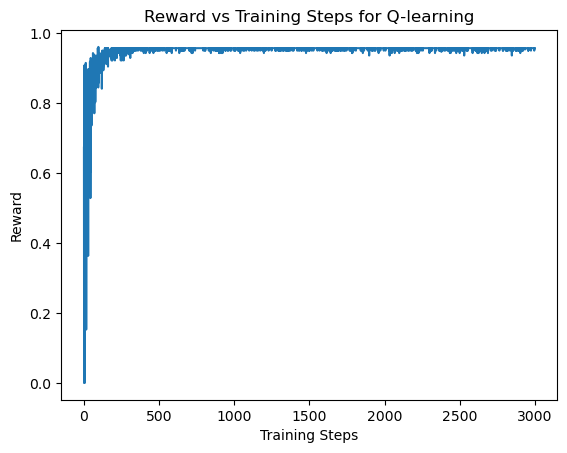

In [15]:
# Set hyperparameters
alpha = 0.1  # learning rate
gamma = 0.85 # discount factor
epsilon_max = 0.99  # maximum exploration rate
epsilon_min = 0.02  # minimum exploration rate
epsilon_decay = 0.99  # exploration rate decay rate


# Call the training function
rewards,Q_qlerarning = train_q_learning(alpha, gamma, epsilon_max, epsilon_min, epsilon_decay)


# Plot the reward as a function of the training steps
plt.plot(range( num_training_episodes ), rewards)
plt.xlabel('Training Steps')
plt.ylabel('Reward')
plt.title('Reward vs Training Steps for Q-learning')
plt.show()

The plot provides insight into the agent's learning progress over time. Initially, at the beginning of training, the reward is low and fluctuating as the agent explores the environment and learns from its actions. As training progresses, the agent gradually improves its policy and decision-making, leading to an increase in the reward. 

At any point during the training we can view the training results using a browser. We first need to start a local TensorBoard server using the following command:

> tensorboard --logdir=runs

We can then view the training results by pointing our browser to the url: http://localhost:6006 which should look like the following:

![Tensorboard example](figures/Tensorboard_example.png)


### Value-function Table (Q-Table)

In [16]:
import pickle
from os.path import exists

filename = 'qlearning.pickle'

# Saving the value-function to file
with open(filename, 'wb') as handle:
    pickle.dump(Q_qlerarning , handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [17]:
# Loading the value-function from file
import pickle
from os.path import exists
filename = 'qlearning.pickle'
if (exists(filename)):
    print('Loading existing Q values')
    # Load data (deserialize)
    with open(filename, 'rb') as handle:
        Q_qlerarning  = pickle.load(handle)
        handle.close()
else:
    print('Filename %s does not exist, could not load data' % filename)       

Loading existing Q values


In [18]:
Q_qlerarning 


{-95638157969374201: array([0.11321167, 0.11278584, 0.16007171]),
 -7985266388802881123: array([0.13183432, 0.13384004, 0.18833545]),
 140815797386113884: array([0.15494157, 0.22159618, 0.10962205]),
 -5966766918654271347: array([0.18692763, 0.18599336, 0.26073603]),
 168227417071064375: array([0.2215263 , 0.14824097, 0.09651998]),
 -3460819865185599556: array([0.08371483, 0.13056391, 0.00021397]),
 -4396329261883780657: array([0.14548096, 0.05222788, 0.05091925]),
 -2767530540588042813: array([0.08087483, 0.15571287, 0.05305625]),
 -7915155303324242828: array([7.39613534e-06, 4.17622161e-04, 6.83369369e-04]),
 -5728459523033898945: array([1.61894950e-06, 3.56122835e-03, 1.32582537e-04]),
 -5208623862047821402: array([0.00000000e+00, 2.18453015e-07, 1.66171139e-02]),
 -5307706131114921641: array([0.00339963, 0.00057985, 0.0643393 ]),
 -6302412860264419234: array([0.0008962 , 0.02048091, 0.00121212]),
 -5449668508784564088: array([0.01166026, 0.00067856, 0.19016042]),
 72933446188729160

### Performance

In [8]:
# Call the training function
completion_rate, average_steps, average_reward= evaluate_q_learning(Q_qlerarning)

print('Episode Completion Rate: {:.2f}%'.format(completion_rate))
print('Average Number of Steps:', average_steps)
print('Average Reward:', average_reward)

Episode Completion Rate: 100.00%
Average Number of Steps: 11.0
Average Reward: 0.9613281250000155


The "Episode Completion Rate" which is presented as a percentage, indicating the proportion of evaluation episodes in which the agent successfully completed its task. In this case, the completion rate is 100.00\%, meaning the agent successfully reached its goal in all evaluation episodes.

The "Average Number of Steps" represents the average number of steps taken by the agent to complete each evaluation episode. Here, the average is 11.0 steps, indicating that, on average, the agent reached its goal in 11 steps.

The "Average Reward" represents the average reward obtained by the agent during the evaluation episodes. The value of 0.961 indicates the average reward achieved. It provides an overall measure of the agent's performance, with higher values indicating better performance.

# 2) Task 2 - Sarsa Algorithm


### Perform Sarsa for a maximum of 3000 episodes

In [19]:
# Initialize the Q-table
Q = {}
num_actions=3   
num_training_episodes=3000
    
def train_sarsa(alpha, gamma, epsilon_max, epsilon_min, epsilon_decay):

    # Tensorboard writer
    writer = SummaryWriter()

    steps_done = 0

    # Training loop
    rewards1 = []
    epsilon = epsilon_max

    #print('Start training...')

    for episode in range(num_training_episodes):
        state = env.reset()
        total_reward1 = 0
        action = epsilon_greedy(state, epsilon)

        for step in range(env.max_steps):
            next_state, reward_, done, truncated, info = env.step(action)
            next_action = epsilon_greedy(next_state, epsilon)

            steps_done += 1

            state_hash = hash_state(state)
            next_state_hash = hash_state(next_state)

            if state_hash not in Q:
                Q[state_hash] = np.zeros(num_actions)

            if next_state_hash not in Q:
                Q[next_state_hash] = np.zeros(num_actions)

            # SARSA update rule
            Q[state_hash][action] += alpha * (reward_ + gamma * Q[next_state_hash][next_action] - Q[state_hash][action])
            total_reward1 += reward_

            if done:
                # If agent reached its goal successfully
                #print('Finished episode successfully taking %d steps and receiving reward %f' % (step, reward_))
                break
            elif truncated:
                # Agent failed to reach its goal successfully
                #print('Truncated episode taking %d steps and receiving reward %f' % (step, reward_))
                break

            state = next_state
            action = next_action

        rewards1.append(total_reward1)

        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)
        writer.add_scalar("Reward/train", reward_, steps_done)

    #print('Training completed.')
    writer.flush()
    writer.close()

    return rewards1, Q

### Average reward as a function of the number of training steps: sarsa

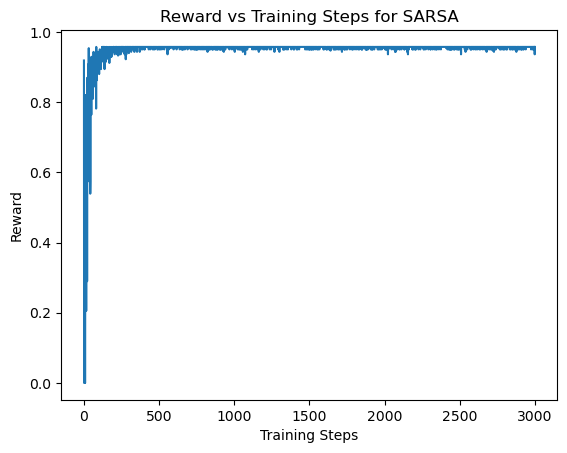

In [24]:
# Set hyperparameters
alpha = 0.1  # learning rate
gamma = 0.85 # discount factor
epsilon_max = 0.99  # maximum exploration rate
epsilon_min = 0.02  # minimum exploration rate
epsilon_decay = 0.99  # exploration rate decay rate


# Call the training function
rewards1, Q_sarsa = train_sarsa(alpha, gamma, epsilon_max, epsilon_min, epsilon_decay)

# Plot the reward as a function of the training steps
plt.plot(range( num_training_episodes ), rewards1)
plt.xlabel('Training Steps')
plt.ylabel('Reward')
plt.title('Reward vs Training Steps for SARSA')
plt.show()

The plot provides insight into the agent's learning progress over time. Initially, at the beginning of training, the reward is low and fluctuating as the agent explores the environment and learns from its actions. As training progresses, the agent gradually improves its policy and decision-making, leading to an increase in the reward.

### Value-function Table (Q-Table) for SARSA

In [25]:
import pickle
from os.path import exists

filename = 'qtablesarsa.pickle'

# Saving the value-function to file
with open(filename, 'wb') as handle:
    pickle.dump(Q_sarsa, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [26]:
# Loading the value-function from file
import pickle
from os.path import exists

filename = 'qtablesarsa.pickle'
if (exists(filename)):
    print('Loading existing Q values')
    # Load data (deserialize)
    with open(filename, 'rb') as handle:
        Q_sarsa = pickle.load(handle)
        handle.close()
else:
    print('Filename %s does not exist, could not load data' % filename)  

Loading existing Q values


In [27]:
Q_sarsa

{-95638157969374201: array([0.06513343, 0.06802126, 0.14622703]),
 3022110103601574297: array([0.11017727, 0.0145914 , 0.00132701]),
 -2451534786469895707: array([3.10461940e-04, 4.55544994e-03, 4.72877698e-06]),
 173429052632756023: array([0.00296019, 0.0001535 , 0.00076029]),
 -8546552515390145075: array([5.69803063e-04, 3.76753042e-05, 2.34040283e-02]),
 4716666414030869633: array([0.0112545 , 0.00037854, 0.09354266]),
 -9055103331742987687: array([0.00130309, 0.01900549, 0.03905278]),
 -4292053335415076878: array([0.02542967, 0.16286577, 0.04436749]),
 168227417071064375: array([0.03030936, 0.04574468, 0.01890456]),
 -5966766918654271347: array([0.14497812, 0.02138022, 0.01217216]),
 140815797386113884: array([0.10824619, 0.07961243, 0.21612381]),
 8891888728824373496: array([0.02050465, 0.02434563, 0.01382255]),
 3334136000786564386: array([0.13882767, 0.015421  , 0.00079654]),
 8068773745060012524: array([0.02494144, 0.01664383, 0.01339644]),
 2517752688579163161: array([0.015167

### Evaluate the performance of the trained policy for sarsa

In [14]:
num_evaluation_episodes=1000
def sarsa():
    num_successes1 = 0
    total_steps1 = 0
    total_reward1 = 0

    for episode in range(num_evaluation_episodes):
        state = env.reset()
        episode_reward1 = 0
        done = False
        num_steps = 0

        while not done:
            action = np.argmax(Q[hash_state(state)])
            next_state, reward_, done, truncated, info = env.step(action)
            episode_reward1 += reward_
            num_steps += 1
            state = next_state

            
        total_reward1 += episode_reward1
        total_steps1 += num_steps
        
        if episode_reward1 > 0:
            num_successes1 += 1

    average_reward1 = total_reward1 / num_evaluation_episodes
    completion_rate1 = num_successes1 / num_evaluation_episodes*100
    average_steps1 = total_steps1 / num_evaluation_episodes
    return completion_rate1, average_steps1, average_reward1  

In [15]:
# Call the training function
completion_rate1, average_steps1, average_reward1= sarsa()

print('Episode Completion Rate: {:.2f}%'.format(completion_rate1))
print('Average Number of Steps:', average_steps1)
print('Average Reward:', average_reward1)

Episode Completion Rate: 100.00%
Average Number of Steps: 12.0
Average Reward: 0.9578125000000169


Based on the provided table, both the SARSA and Q-learning algorithms achieve a 100\% completion rate, indicating that they are successful in reaching the goal in all evaluated episodes. However, there are slight differences in the average number of steps and average reward.

In terms of the average number of steps, the Q-learning algorithm performs slightly better with an average of 11.0 steps, compared to SARSA which has an average of 12.0 steps. This suggests that Q-learning finds more efficient paths to reach the goal on average.

Regarding the average reward, both algorithms have similar performance, with Q-learning achieving an average reward of 0.961 and SARSA achieving an average reward of 0.957. This indicates that both algorithms are able to obtain high rewards on average but Q-learning is slightly more better.